In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import stats
xr.set_options(keep_attrs=True)
import sys
sys.path.insert(1, './../')
import asym_funcs as af
import importlib
importlib.reload(af)

<module 'asym_funcs' from '/glade/u/home/lettier/analysis/analysis_temp-asym/pub/analysis/./../asym_funcs.py'>

In [2]:
ds = xr.open_dataset('../obsdata/daily_TREFHT_ERA5_1979-2018mean.nc')
ds = ds.where(abs(ds.lat)>20)
ds_f = af.xr_fourier_decomp (ds.dayofyear/len(ds.dayofyear), ds, 4, 'dayofyear')
a, t1 ,t2  =  af.asym_xr(ds_f,'dayofyear')
obds = -a.rename({'VAR_2T':'T_delta'})

In [3]:
datadir = '../simplemodel/output/'

In [4]:
def calc_delta_from_ode (datadir, fname):

    odeds = xr.open_dataset(datadir+fname)
    a, t1, t2 = af.asym_xr(odeds.T,dim='time')
    a = -a/1000.*365
    t1 = t1/1000.*365
    t2 = t2/1000.*365

    a = a.to_dataset(name='T_delta')
    t1 = t1.to_dataset(name='T_t1')
    t2 = t2.to_dataset(name='T_t2')
    ds = xr.merge([odeds, a, t1, t2])
    ds.attrs['desc'] = '20y climatology'
    ds.T_delta.attrs['units'] = 'd'
    ds.T_t1.attrs['units'] = 'd'
    ds.T_t2.attrs['units'] = 'd'
    ds = ds.where(abs(ds.lat)>20)
    
    return ds

In [5]:
ds =  calc_delta_from_ode (datadir, 'ODEn800_TOAinsolation.nc')
zds = calc_delta_from_ode (datadir, 'ODEn800_TOAinsolation_zeroecc.nc')

In [6]:
obds_nh = obds.where(obds.lat>0,drop=True)
obds_sh = obds.where(obds.lat<0,drop=True)
obds_sh['lat'] = -obds_sh.lat
obds_sh = obds_sh.interp(lat = obds_nh.lat)

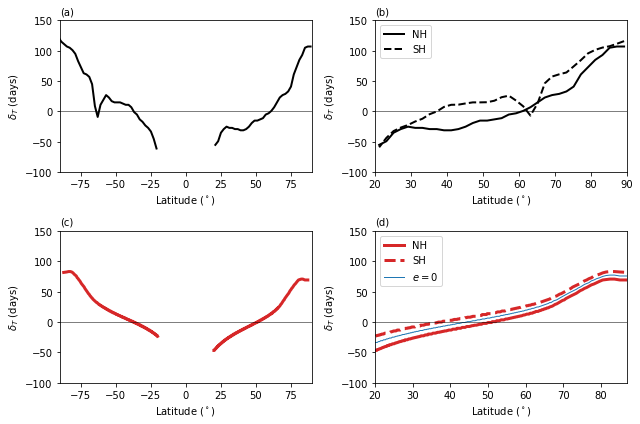

In [7]:
fig = plt.figure(figsize=(9,6))

ax = plt.subplot(2,2,1)
obds.T_delta.plot(ax=ax,linewidth=2, c='k')
ax.set_title('(a)',loc='left',fontsize=10)
ax.set_xlim([-90,90])
ax.set_ylim([-100,150])
ax.set_ylabel('$\delta_T$ (days)')
ax.set_xlabel('Latitude ($^\circ$)')
ax.axhline(y=0,c='k',linewidth = 0.5)

ax = plt.subplot(2,2,2)
obds_nh.T_delta.plot(ax=ax,label='NH', linewidth=2, c='k')
obds_sh.T_delta.plot(ax=ax,label='SH', linewidth=2, c='k',linestyle='--')

ax.set_title('(b)',loc='left',fontsize=10)
ax.set_xlim([20,90])
ax.set_ylim([-100,150])
ax.set_ylabel('$\delta_T$ (days)')
ax.set_xlabel('Latitude ($^\circ$)')
plt.legend()
ax.axhline(y=0,c='k',linewidth = 0.5)

ax = plt.subplot(2,2,3)
ds.T_delta.plot(ax=ax,label='ODE - TOA down',linewidth=3,c='tab:red')
ax.set_title('')
ax.set_title('(c)',loc='left',fontsize=10)
ax.set_xlim([-90,90])
ax.set_ylim([-100,150])
ax.set_ylabel('$\delta_T$ (days)')
ax.set_xlabel('Latitude ($^\circ$)')
ax.axhline(y=0,c='k',linewidth = 0.5)

ax = plt.subplot(2,2,4)
ds.T_delta.plot(ax=ax,label='NH',linewidth=3,c='tab:red')
ax.plot(ds.lat,ds.T_delta.values[::-1],label='SH',linewidth=3,c='tab:red',linestyle='--')
zds.T_delta.plot(ax=ax,label='$e=0$',linewidth=1,c='tab:blue')
plt.legend(loc='upper left')
ax.set_title('')
ax.set_title('(d)',loc='left',fontsize=10)
ax.set_xlim([20,87])
ax.set_ylim([-100,150])
ax.set_ylabel('$\delta_T$ (days)')
ax.set_xlabel('Latitude ($^\circ$)')
ax.axhline(y=0,c='k',linewidth = 0.5)

plt.tight_layout()
fig.savefig('../figs/fig2.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [8]:
ds.lat.diff(dim='lat').min()

<xarray.DataArray 'lat' ()>
array(0.14323949)
Coordinates:
    names    <U13 'TOAinsolation'

In [9]:
obds_nh = obds_nh.where(obds_sh==obds_sh,drop=True)
obds_sh = obds_sh.where(obds_nh==obds_nh,drop=True)

print('Difference in means: {:.2f} days'.format(obds_nh.T_delta.mean().values - obds_sh.T_delta.mean().values))
print('Mean difference: {:.2f} days'.format((obds_nh-obds_sh).T_delta.mean().values))

Difference in means: -19.80 days
Mean difference: -19.80 days


In [10]:
myds_nh = ds.where(ds.lat>20)
myds_sh = ds.where(ds.lat<-20)
myds_sh['lat'] = - myds_sh.lat
myds_sh = myds_sh.interp(lat = myds_nh.lat)

In [11]:
myds_nh = myds_nh.where(myds_sh==myds_sh,drop=True)
myds_sh = myds_sh.where(myds_nh==myds_nh,drop=True)

print('Difference in means: {:.2f} days'.format(myds_nh.T_delta.mean().values - myds_sh.T_delta.mean().values))
print('Mean difference: {:.2f} days'.format((myds_nh-myds_sh).T_delta.mean().values))

Difference in means: -16.31 days
Mean difference: -16.31 days


Now plot multiple model simulations

In [12]:
def single_panel_plot(plotdata, plotlabels, plotcolors, plotls = ['-','-'],
                      plot_obs = True, fig_name = ''):
    
    fig, ax = plt.subplots(1,figsize=(5,3.5))

    for p, mydata in enumerate(plotdata):
        mydata.T_delta.plot(ax=ax, label=plotlabels[p], linewidth=2,c=plotcolors[p],linestyle=plotls[p])
     
    if plot_obs:
        obds.T_delta.plot(ax=ax,label='ERA5', linewidth=2, c='k')

    ax.set_title('')
    ax.set_xlim([-87,87])
    ax.set_ylim([-100,150])

    ax.set_ylabel('$\delta_T$ (days)')
    ax.set_xlabel('Latitude ($^\circ$)')
    plt.legend()
    ax.axhline(y=0,c='k',linewidth = 0.5)
    
    if fig_name != '':
        fig.savefig(fig_name,dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()
    
    return

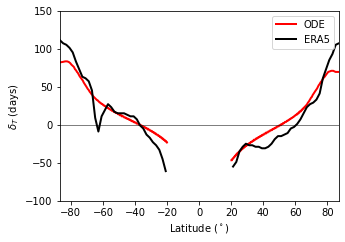

In [13]:
single_panel_plot([calc_delta_from_ode (datadir, 'ODEn800_TOAinsolation.nc')],['ODE'],'r')

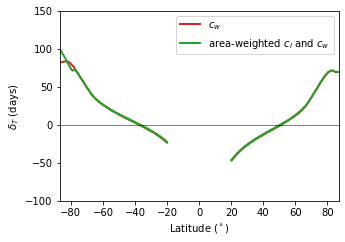

In [14]:
fig_name = '../figs/meridional_asym_temp_OBS_ODE_weightheatcap.pdf'
single_panel_plot([calc_delta_from_ode (datadir, 'ODEn800_TOAinsolation.nc'),
                   calc_delta_from_ode (datadir, 'ODEn800_TOAinsolation_wgtheatcap.nc')],
                  ['$c_w$','area-weighted $c_l$ and $c_w$'], ['tab:red','tab:green'],plot_obs=False,  fig_name = '../figs/figS5.pdf')

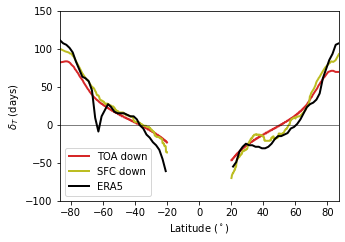

In [15]:
fig_name = '../figs/meridional_asym_temp_OBS_ODE_SWdown.pdf'
single_panel_plot([calc_delta_from_ode (datadir, 'ODEn800_TOAinsolation.nc'),
                   calc_delta_from_ode (datadir, 'ODEn800_CERES_SFC-SW-down.nc')],
                  ['TOA down','SFC down'], ['tab:red','tab:olive'], fig_name = '../figs/figS6.pdf')

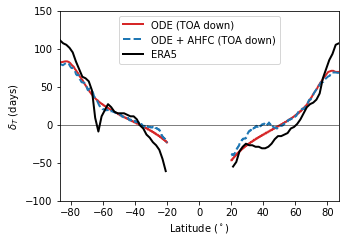

In [16]:
fig_name = '../figs/meridional_asym_temp_OBS_ODE_AHFC.pdf'
single_panel_plot([calc_delta_from_ode (datadir, 'ODEn800_TOAinsolation.nc'),
                   calc_delta_from_ode (datadir, 'ODEn800_TOAinsolationPLUSheatconv.nc')],
                  ['ODE (TOA down)','ODE + AHFC (TOA down)'], ['tab:red','tab:blue'], ['-','--'], fig_name = '../figs/figS7.pdf')

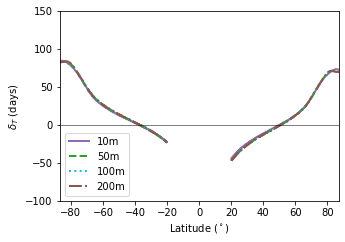

In [17]:
fig_name = '../figs/meridional_asym_temp_OBS_ODE_varyCW.pdf'
mylist = [calc_delta_from_ode (datadir, 'ODEn800_TOAinsolation_MLD'+str(i)+'m.nc') for i in [10,50,100,200]]
single_panel_plot(mylist,['10m','50m','100m','200m'], ['tab:purple','tab:green','tab:cyan','tab:brown'], 
                  ['-','--',':','-.'], plot_obs=False, fig_name = '../figs/figS4.pdf')

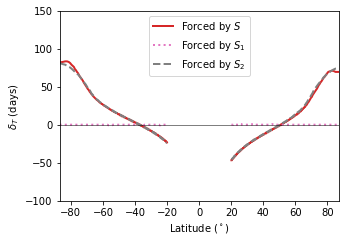

In [18]:
fig_name = '../figs/fourier_insolation.pdf'
mylist = [calc_delta_from_ode (datadir, 'ODEn800_TOAinsolation.nc'),
         calc_delta_from_ode (datadir, 'ODEn800_TOAinsolation_fourier1.nc'),
         calc_delta_from_ode (datadir, 'ODEn800_TOAinsolation_fourier2.nc'),]

single_panel_plot(mylist,['Forced by $S$','Forced by $S_1$','Forced by $S_2$'], 
                  ['tab:red','tab:pink','grey'], ['-',':','--'], plot_obs=False, fig_name = '../figs/figS3.pdf')

In [20]:
S =  xr.open_dataset('../simplemodel/forcingdata/forcing_TOAinsolation_n800.nc')
S1 = xr.open_dataset('../simplemodel/forcingdata/forcing_TOAinsolation_fourier1_n800.nc')
S2 = xr.open_dataset('../simplemodel/forcingdata/forcing_TOAinsolation_fourier2_n800.nc')

In [21]:
T = xr.open_dataset('../simplemodel/output/ODEn800_TOAinsolation.nc') 
T1 = xr.open_dataset('../simplemodel/output/ODEn800_TOAinsolation_fourier1.nc')
T2 = xr.open_dataset('../simplemodel/output/ODEn800_TOAinsolation_fourier2.nc')

In [22]:
colors = ['#000080','orange','tomato','#1b9e77','tomato', '#000080', '#FFA500', 'skyblue','tomato']
ls = ['-','--','--','-.','-']

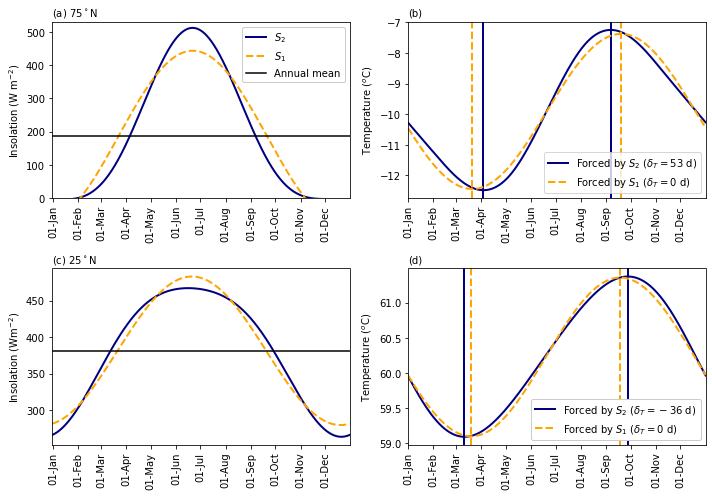

In [23]:
fig, ax = plt.subplots(1,figsize=(10,7))

ax = plt.subplot(2,2,1)
mylat = 75
S2.S.interp(lat=mylat).plot(ax=ax,label='$S_2$',c=colors[0],linewidth=2)
S1.S.interp(lat=mylat).plot(ax=ax,label='$S_1$',c=colors[1],linestyle='--',linewidth=2)
ax.axhline(y=S.S.interp(lat=mylat).mean(dim='time').values,c='k',label='Annual mean')

ax.set_xlim([0,1])
ax.set_ylim([0,530])
ax.set_ylabel('Insolation (W m$^{-2}$)')
ax.set_xlabel('')
ax.set_title('')
ax.set_title('(a) '+str(int(mylat))+'$^\circ$N',loc='left',fontsize=10)
plt.legend(facecolor='white', framealpha=1)
ax.set_xticks(np.linspace(0,1,366)[af.firstofmonthind])
ax.set_xticklabels(af.firstofmonthlabel,rotation='vertical')


ax = plt.subplot(2,2,2)
for p, mydata in enumerate([T.T.interp(lat=mylat).values,T1.T.interp(lat=mylat).values]):
    a, dmax, dmin = af.asym_1d(mydata)
    a = -a/1000.*365.

    label=['Forced by $S_2$', 'Forced by $S_1$'][p]+' ($\delta_T= {0}$ d'.format(np.int(np.round(a)))+')'
    ax.plot(np.linspace(1,366,len(mydata)),mydata,label=label,c=colors[p],linestyle=ls[p],linewidth=2)
    ax.axvline(np.linspace(1,366,1000)[int(dmax)],linewidth=2,c=colors[p],linestyle=ls[p])
    ax.axvline(np.linspace(1,366,1000)[int(dmin)],linewidth=2,c=colors[p],linestyle=ls[p])
ax.set_xticks(af.firstofmonthind )
ax.set_xticklabels(af.firstofmonthlabel,rotation='vertical')
ax.set_xlim([1,366])
ax.legend()
ax.set_ylabel('Temperature ($^{o}$C)')
#ax.get_yaxis().set_visible(False)
ax.set_title('(b)',loc='left',fontsize=10)

ax = plt.subplot(2,2,3)
mylat = 25
S2.S.interp(lat=mylat).plot(ax=ax,label='2 harmonics',c=colors[0],linewidth=2)
S1.S.interp(lat=mylat).plot(ax=ax,label='1 harmonic',c=colors[1],linestyle='--',linewidth=2)
ax.axhline(y=S.S.interp(lat=mylat).mean().values,c='k',label='Annual mean')
ax.set_xlim([0,1])
ax.set_ylabel('Insolation (Wm$^{-2}$)')
ax.set_xlabel('')
ax.set_title('')
ax.set_title('(c) '+str(int(mylat))+'$^\circ$N',loc='left',fontsize=10)
ax.set_xticks(np.linspace(0,1,366)[af.firstofmonthind])
ax.set_xticklabels(af.firstofmonthlabel,rotation='vertical')



ax = plt.subplot(2,2,4)
for p, mydata in enumerate([T.T.interp(lat=mylat).values,T1.T.interp(lat=mylat).values]):
    a, dmax, dmin = af.asym_1d(mydata)
    a = -a/1000.*365.
    label=['Forced by $S_2$', 'Forced by $S_1$'][p]+' ($\delta_T= {0}$ d'.format(np.int(np.round(a)))+')'
    ax.plot(np.linspace(1,366,len(mydata)),mydata,label=label,c=colors[p],linestyle=ls[p],linewidth=2)
    ax.axvline(np.linspace(1,366,1000)[int(dmax)],linewidth=2,c=colors[p],linestyle=ls[p])
    ax.axvline(np.linspace(1,366,1000)[int(dmin)],linewidth=2,c=colors[p],linestyle=ls[p])

ax.legend(facecolor='white', framealpha=1)
ax.set_ylabel('Temperature ($^{o}$C)')
ax.set_xticks(af.firstofmonthind )
ax.set_xticklabels(af.firstofmonthlabel,rotation='vertical')
ax.set_xlim([1,366])
#ax.get_yaxis().set_visible(False)
ax.set_title('(d)',loc='left',fontsize=10)
plt.tight_layout()
plt.show()
fig.savefig('../figs/fig3.pdf',bbox_inches='tight')
plt.close()